In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset
from data.NoisyDataset import NoisyDataset

# Parameters

In [8]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'
activations_dir = f'{engram_dir}activations_pnet/'

In [9]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


# Function to collect accuracy values

In [10]:
def eval_accuracy(
    results, dset, ff_correct=None, clean_correct=None
    ):
    
    idxs = np.ones(dset.n_data).astype(bool)
    if ff_correct is not None:
        if ff_correct:
            idxs = np.logical_and(idxs, np.logical_not(dset.net_mistakes))
        else:
            idxs = np.logical_and(idxs, dset.net_mistakes)
    if clean_correct is not None:
        clean_correct_idxs = dset.labels == np.array(results['0_clean_output'])
        if clean_correct:
            idxs = np.logical_and(idxs, clean_correct_idxs)
        else:
            idxs = np.logical_and(idxs, np.logical_not(clean_correct_idxs))
    idxs = np.argwhere(idxs).squeeze()
    timesteps = []
    accuracies = []
    
    n_timesteps = 5
    for i in idxs:
        clean_input = dset.clean_in[i].reshape((164, 400))
        label = results['label'][i]
        for t in range(n_timesteps):
            output = results[f'{t}_output'][i]
            timesteps.append(t)
            accuracies.append(output == label)
            
    return timesteps, accuracies

In [11]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [12]:
bgs = ['AudScene', 'Babble8Spkr']
snrs = [-9.0, -6.0, -3.0, 0.0, 3.0]

# All

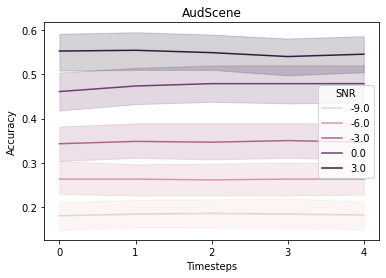

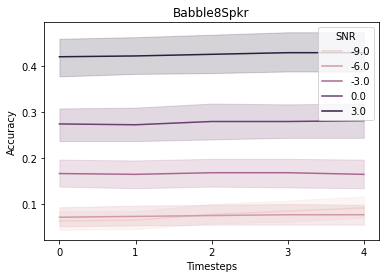

In [13]:
for bg in bgs:
    data = {}
    data['Timesteps'] = []
    data['Accuracy'] = []
    data['SNR'] = []
    for snr in snrs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, accs = eval_accuracy(results, dset)
        data['Timesteps'].extend(timesteps)
        data['Accuracy'].extend(accs)
        data['SNR'].extend([snr]*len(accs))
    df = pd.DataFrame(data)
    g = sns.lineplot(x='Timesteps', y='Accuracy', hue='SNR', data=df)
    plt.title(f'{bg}')
    plt.xticks([0, 1, 2, 3, 4])
    plt.show(g)

# FF Incorrect, Clean Correct

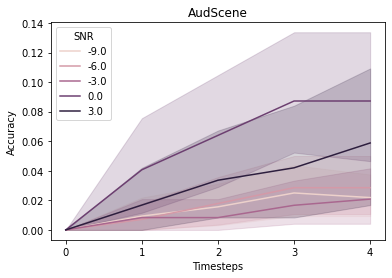

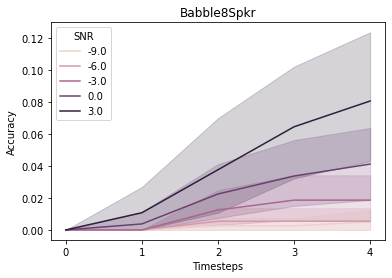

In [14]:
for bg in bgs:
    data = {}
    data['Timesteps'] = []
    data['Accuracy'] = []
    data['SNR'] = []
    for snr in snrs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, accs = eval_accuracy(
            results, dset, ff_correct=False, clean_correct=True
            )
        data['Timesteps'].extend(timesteps)
        data['Accuracy'].extend(accs)
        data['SNR'].extend([snr]*len(accs))
    df = pd.DataFrame(data)
    g = sns.lineplot(x='Timesteps', y='Accuracy', hue='SNR', data=df)
    plt.title(f'{bg}')
    plt.xticks([0, 1, 2, 3, 4])
    plt.show(g)

# FF Correct, Clean Correct

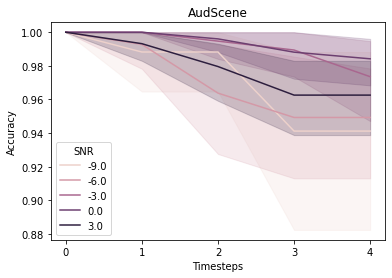

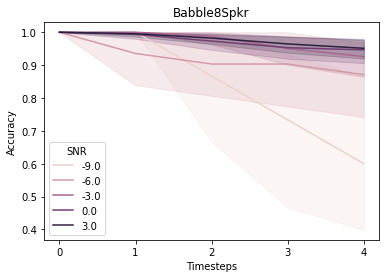

In [15]:
for bg in bgs:
    data = {}
    data['Timesteps'] = []
    data['Accuracy'] = []
    data['SNR'] = []
    for snr in snrs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, accs = eval_accuracy(
            results, dset, ff_correct=True, clean_correct=True
            )
        data['Timesteps'].extend(timesteps)
        data['Accuracy'].extend(accs)
        data['SNR'].extend([snr]*len(accs))
    df = pd.DataFrame(data)
    g = sns.lineplot(x='Timesteps', y='Accuracy', hue='SNR', data=df)
    plt.title(f'{bg}')
    plt.xticks([0, 1, 2, 3, 4])
    plt.show(g)

# FF Incorrect, Clean Incorrect

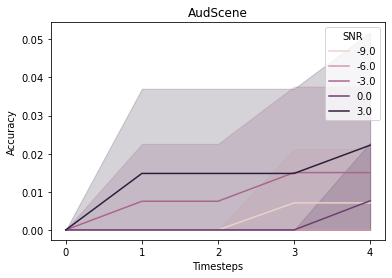

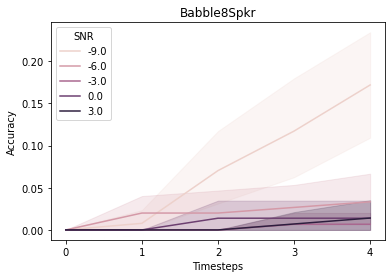

In [16]:
for bg in bgs:
    data = {}
    data['Timesteps'] = []
    data['Accuracy'] = []
    data['SNR'] = []
    for snr in snrs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, accs = eval_accuracy(
            results, dset, ff_correct=False, clean_correct=False
            )
        data['Timesteps'].extend(timesteps)
        data['Accuracy'].extend(accs)
        data['SNR'].extend([snr]*len(accs))
    df = pd.DataFrame(data)
    g = sns.lineplot(x='Timesteps', y='Accuracy', hue='SNR', data=df)
    plt.title(f'{bg}')
    plt.xticks([0, 1, 2, 3, 4])
    plt.show(g)